In [3]:
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder



In [4]:
# File ID from shared Google Drive link
file_id = "1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV"
url = f"https://drive.google.com/uc?id={file_id}"

# Save to temp file (in Colab's RAM)
output = "/tmp/fraud.csv"
gdown.download(url, output, quiet=False)

# Read with pandas (works like streaming from Drive)
df = pd.read_csv(output)
df.head()


Downloading...
From (original): https://drive.google.com/uc?id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV
From (redirected): https://drive.google.com/uc?id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV&confirm=t&uuid=0053b549-0ddb-45c4-b288-48f116a36bd7
To: /tmp/fraud.csv
100%|██████████| 494M/494M [00:06<00:00, 70.7MB/s]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [6]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

Preprocessing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [9]:
df.shape

(6362620, 11)

In [10]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [11]:
df.nunique()

,0
step,743
type,5
amount,5316900
nameOrig,6353307
oldbalanceOrg,1845844
newbalanceOrig,2682586
nameDest,2722362
oldbalanceDest,3614697
newbalanceDest,3555499
isFraud,2


In [12]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [13]:
df['isFlaggedFraud'].value_counts()

,count
isFlaggedFraud,
0,6362604
1,16


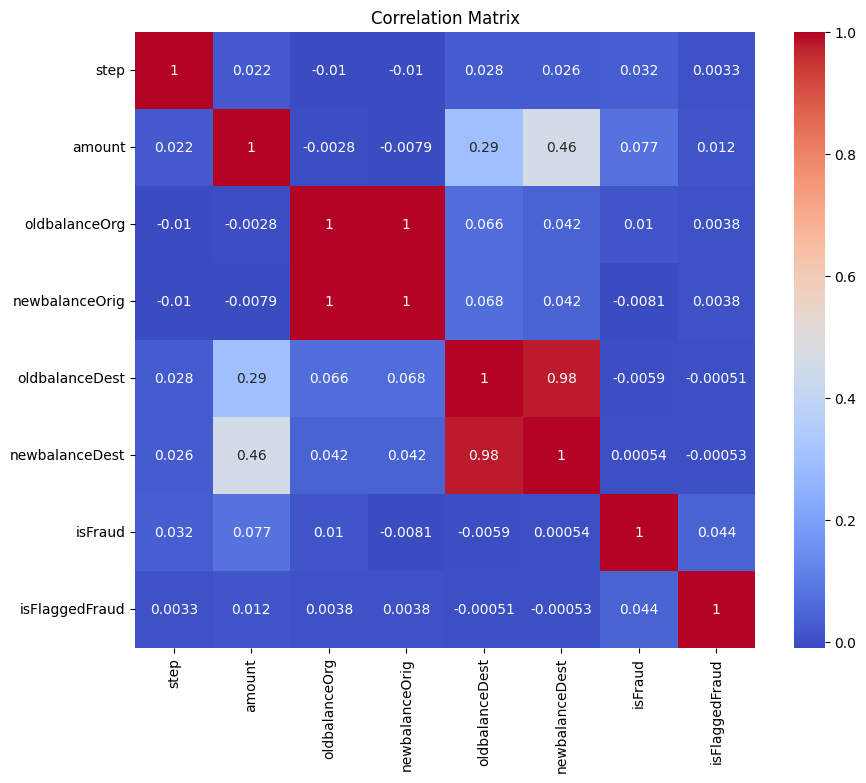

In [27]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [28]:
threshold = 0.7
correlated_features=[]
for i in range(len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i, j]>threshold):
      col_i = correlation_matrix.columns[i]
      col_j = correlation_matrix.columns[j]
      correlated_features.append((col_i, col_j, correlation_matrix.iloc[i, j]))

In [29]:
correlated_features

[('newbalanceOrig', 'oldbalanceOrg', np.float64(0.9988027631723787)),
 ('newbalanceDest', 'oldbalanceDest', np.float64(0.9765685054474923))]

In [30]:
X = df.drop('isFraud', axis= 1)  #Features
Y = df['isFraud']  #target

In [31]:
categorical_cols = X.select_dtypes(include=['object']).columns

for col in categorical_cols:
  le = LabelEncoder()
  X[col] = le.fit_transform(X[col])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, Y_train)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, Y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
def evaluate_model(model, X, Y):
  y_pred = model.predict(X)
  accuracy = accuracy_score(Y, y_pred)
  precision = precision_score(Y, y_pred)
  recall = recall_score(Y, y_pred)
  f1 = f1_score(Y, y_pred)
  return accuracy, precision, recall, f1

In [33]:
lr_accuracy, lr_precision, lr_recall, lr_f1 = evaluate_model(lr_model, X_test, Y_test)
dt_accuracy, dt_precision, dt_recall, dt_f1 = evaluate_model(dt_model, X_test, Y_test)
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = evaluate_model(xgb_model, X_test, Y_test)

In [34]:
# Print the evaluation metrics
print("Logistic Regression - Accuracy:", lr_accuracy, "Precision:", lr_precision, "Recall:", lr_recall, "f1 Score:", lr_f1)
print("Decision Tree - Accuracy:", dt_accuracy, "Precision:", dt_precision, "Recall:", dt_recall, "f1 Score:", dt_f1)
print("XGBoost - Accuracy:", xgb_accuracy, "Precision:", xgb_precision, "Recall:", xgb_recall, "f1 Score:", xgb_f1)

Logistic Regression - Accuracy: 0.9991214311085684 Precision: 0.7820224719101123 Recall: 0.42962962962962964 f1 Score: 0.5545816733067729
Decision Tree - Accuracy: 0.9997029525572798 Precision: 0.8935361216730038 Recall: 0.8703703703703703 f1 Score: 0.8818011257035647
XGBoost - Accuracy: 0.999761104702151 Precision: 0.9537931034482758 Recall: 0.8537037037037037 f1 Score: 0.9009771986970684
